In [1]:
import json
import tensorflow as tf
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
import matplotlib.path as mplPath

from fr3D.train.utils import setup_datasets
from fr3D.data.utils import get_normalization_type
from fr3D.models import ConvAutoencoder, ConvAutoencoderCGAN, ConvAutoencoderC
from fr3D.utils import mape_with_threshold

In [2]:
Re = 500
expt_variables = ['Pressure', 'U', 'V', 'W']

dataset_path = f'/fr3D/postprocessed/annulus_64.h5'

#ConvAutoencoderC
experiment_configs = {expt_variable:f'/fr3D/configs/training/ConvAutoencoderC_{expt_variable}.json' for expt_variable in expt_variables}
weights_paths = {expt_variable:f'/storage/weights{Re}/ConvAutoencoderC_{expt_variable}_Annulus64/ConvAutoencoderC_{expt_variable}_Annulus64.h5' for expt_variable in expt_variables}



datasetf = h5py.File(dataset_path,'r')

shuf_buf = 1

train_datasets = {}
test_datasets = {}
sensor_shapes = {}
full_field_shapes = {}
normalizers = {}

for expt_variable in experiment_configs:
    config = json.load(open(experiment_configs[expt_variable],'r'))
    train_datasets[expt_variable], test_datasets[expt_variable] = setup_datasets(config, dataset_path, shuf_buf, case_names=True, evaluation=True)
    sensor_shapes[expt_variable] = train_datasets[expt_variable].element_spec[0][0].shape
    full_field_shapes[expt_variable] = train_datasets[expt_variable].element_spec[0][1].shape
    normalizers[expt_variable] = get_normalization_type(config['dataset']['node_configurations'])

Training geometries: ('shape_69', 'shape_33', 'shape_37', 'shape_374', 'shape_239', 'shape_224', 'shape_160', 'shape_237', 'shape_135', 'cylinder', 'shape_152', 'shape_186', 'shape_92', 'shape_21', 'shape_58', 'shape_110', 'shape_88', 'shape_59', 'shape_14', 'shape_197', 'shape_55', 'shape_8', 'shape_170', 'shape_234', 'shape_43', 'shape_149', 'shape_228', 'shape_48', 'shape_130', 'shape_90', 'shape_137', 'shape_84', 'shape_361', 'shape_182', 'shape_68', 'shape_113', 'shape_244', 'shape_327', 'shape_216', 'shape_15', 'shape_63', 'shape_213', 'shape_126', 'shape_236', 'shape_50', 'shape_18', 'shape_157', 'shape_89', 'shape_17', 'shape_355', 'shape_29', 'shape_146', 'shape_164', 'shape_11', 'shape_150', 'shape_220', 'shape_13', 'shape_60', 'shape_12', 'shape_369', 'shape_218', 'shape_78', 'shape_331', 'shape_97', 'shape_329', 'shape_31', 'shape_39', 'shape_241', 'shape_41', 'shape_346', 'shape_94', 'shape_61', 'shape_23', 'shape_339', 'shape_255', 'shape_83', 'shape_338', 'shape_54', 'sh

2022-12-20 20:39:20.009554: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-12-20 20:39:20.009723: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-12-20 20:39:20.329650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 20:39:21.206553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38278 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-20 20:39:21.208088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] 

Training geometries: ('shape_69', 'shape_33', 'shape_37', 'shape_374', 'shape_239', 'shape_224', 'shape_160', 'shape_237', 'shape_135', 'cylinder', 'shape_152', 'shape_186', 'shape_92', 'shape_21', 'shape_58', 'shape_110', 'shape_88', 'shape_59', 'shape_14', 'shape_197', 'shape_55', 'shape_8', 'shape_170', 'shape_234', 'shape_43', 'shape_149', 'shape_228', 'shape_48', 'shape_130', 'shape_90', 'shape_137', 'shape_84', 'shape_361', 'shape_182', 'shape_68', 'shape_113', 'shape_244', 'shape_327', 'shape_216', 'shape_15', 'shape_63', 'shape_213', 'shape_126', 'shape_236', 'shape_50', 'shape_18', 'shape_157', 'shape_89', 'shape_17', 'shape_355', 'shape_29', 'shape_146', 'shape_164', 'shape_11', 'shape_150', 'shape_220', 'shape_13', 'shape_60', 'shape_12', 'shape_369', 'shape_218', 'shape_78', 'shape_331', 'shape_97', 'shape_329', 'shape_31', 'shape_39', 'shape_241', 'shape_41', 'shape_346', 'shape_94', 'shape_61', 'shape_23', 'shape_339', 'shape_255', 'shape_83', 'shape_338', 'shape_54', 'sh

In [55]:
def circular_pad(x, coords=True):
    if coords:
        r = np.zeros((x.shape[0]+2, x.shape[1]+2, x.shape[2]))
    else:
        r = np.zeros((x.shape[0]+2, x.shape[1]+2))
    r[1:-1,1:-1] = x
    
    r[0,1:-1] = x[-1]
    r[-1,1:-1] = x[0]
    
    if coords:
        r[:,0,:2] = r[:,1,:2]
        r[:,0,2] = x[0,0,2] - x[0,1,2]
        
        r[:,-1,:2] = r[:,-2,:2]
        r[:,-1,2] = 2*x[0,-1,2] - x[0,-2,2]
    return r

def compute_surface_normals(ds, normalize=True):
    r = {}
    for shape in ds:
        deltas = ds[shape]['full_field_coords'][1] - ds[shape]['full_field_coords'][0]
        if normalize:
            normals = deltas / np.linalg.norm(deltas,axis=-1,keepdims=True)
        else:
            normals = deltas
        r[shape] = tf.convert_to_tensor(normals)
    return r

@tf.function
def surface_integrate(vertex_values, vertex_coords):
    
    padded_coords = tf.concat([vertex_coords, vertex_coords[:1]],0)
    padded_values = tf.concat([vertex_values, vertex_values[:1]],0)
    
    cell_mean_values = tf.nn.conv2d(
        tf.convert_to_tensor([[padded_values]]),
        tf.constant([[[[0.25]],[[0.25]]],[[[0.25]],[[0.25]]]]),
        1, "VALID", data_format="NCHW"
    )[0,0]
    
    z_direction_vector = padded_coords[:-1, 1:] - padded_coords[:-1, :-1]
    theta_direction_vector = -(padded_coords[1:,:-1] - padded_coords[:-1,:-1])
    cell_normals = tf.linalg.cross(theta_direction_vector, z_direction_vector)
    cell_areas = tf.linalg.norm(cell_normals, axis=-1)
    
    return tf.einsum('tzn,tz->n', cell_normals, cell_mean_values)#/(0.5*1.0*(1.0**2)*tf.reduce_sum(cell_areas))

@tf.function
def surface_area(vertex_coords):
    
    padded_coords = tf.concat([vertex_coords, vertex_coords[:1]],0)
    z_direction_vector = padded_coords[:-1, 1:] - padded_coords[:-1, :-1]
    theta_direction_vector = -(padded_coords[1:,:-1] - padded_coords[:-1,:-1])
    cell_normals = tf.linalg.cross(theta_direction_vector, z_direction_vector)
    cell_areas = tf.linalg.norm(cell_normals, axis=-1)
    
    return tf.reduce_sum(cell_areas)

@tf.function
def compute_shear_stresses(velocities, surface_normals, nu=1.0):
    #get surface tangent component of velocity    
    R = tf.constant([[0,-1,0],[1,0,0],[0,0,1]],dtype=velocities.dtype)
    surface_normals_norm = tf.linalg.norm(surface_normals, axis=-1, keepdims=True)
    surface_unit_tangents = tf.einsum('ij,tzj->tzi', R, surface_normals/surface_normals_norm)
    velocity_tangent_component = tf.einsum('tzi,tzi->tz', surface_unit_tangents, velocities[1])
    
    #compute shear stresses from du/dn
    tau = nu*velocity_tangent_component/(2*surface_normals_norm[...,0]**2.0)
    return tau

@tf.function
def compute_friction_forces(shear_stresses, vertex_coords):
    Fnormal = surface_integrate(shear_stresses, vertex_coords)
    return tf.convert_to_tensor([Fnormal[1], -Fnormal[0], Fnormal[2]])

In [4]:
models = {}

for v in expt_variables:
    config = json.load(open(experiment_configs[v],'r'))
    model = ConvAutoencoderC(dense_input_units=sensor_shapes[v][1],
                             autoencoder_input_shape=full_field_shapes[v][1:],
                             **config['model'])
    loss_fn = "mse"#tf.keras.losses.get(config['training']['loss'])
    model.compile(l_optimizer= tf.keras.optimizers.get(config['training']['l_optimizer']),
                  loss=loss_fn,
                  optimizer = tf.keras.optimizers.get(config['training']['ae_optimizer']),
                  metrics = config['training'].get('metrics', None))
    model.load_weights(weights_paths[v])
    models[v] = model

In [185]:
@tf.function
def _surface_integrate_wrap(x):
    return surface_integrate(x[0], x[1])

@tf.function
def _friction_forces(x):
    velocities, surface_normals, coords = x
    nu = 0.01
    tau = compute_shear_stresses(velocities, surface_normals, nu)
    friction_forces = compute_friction_forces(tau, coords)
    return friction_forces

@tf.function
def get_predictions(model, inp, target):
    return model(inp, autoencode=False), model(target, autoencode=True)

def undo_normalization(normalizer, norm_param, pred, ae_pred, target):
    ntarget = normalizer.undo(target, norm_param[:,0,:])
    npred = normalizer.undo(pred, norm_param[:,0,:])
    nae_pred = normalizer.undo(ae_pred, norm_param[:,0,:])
    return npred, nae_pred, ntarget

@tf.function
def check_in_box(coords, bounds_lower, bounds_upper):
    newshape = tf.concat([tf.ones((tf.rank(coords)-1,), dtype=tf.int32), tf.shape(bounds_lower)[:1]],0)
    bounds_lower_r = tf.reshape(bounds_lower, newshape)
    bounds_upper_r = tf.reshape(bounds_upper, newshape)
    lower_cond = tf.reduce_all(coords > bounds_lower, axis=-1)
    upper_cond = tf.reduce_all(coords < bounds_upper, axis=-1)
    return tf.logical_and(lower_cond, upper_cond)

def compute_metrics(coords, v, mapes, umapes, mses, umses, pred, target, npred, ntarget):
    lower_box_bounds = tf.constant([-3.0,-3.0,-0.1])
    upper_box_bounds = tf.constant([8.0,3.0,10.1])
    in_box = check_in_box(coords, lower_box_bounds, upper_box_bounds)
    in_box_r = tf.reshape(in_box, tf.concat([tf.shape(in_box), tf.ones((tf.rank(p_npred) - tf.rank(in_box),), tf.int32)], 0))
    in_box_rf = tf.cast(in_box_r, tf.float32)
    
    _lf =tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    
    mapes[v].append(
        mape_with_threshold(npred, ntarget, pcterror_threshold=100.0, max_magnitude_threshold=0.03, sample_weights=in_box_rf, axis=tf.range(1, tf.rank(in_box_rf)))
    )
    umapes[v].append(
        mape_with_threshold(pred, target, pcterror_threshold=100.0, max_magnitude_threshold=0.03, sample_weights=in_box_rf, axis=tf.range(1, tf.rank(in_box_rf)))
    )
    mses[v].append(tf.reduce_mean(_lf(npred, ntarget, in_box_rf), axis=tf.range(1, tf.rank(in_box_rf)-1)))
    umses[v].append(tf.reduce_mean(_lf(pred, target, in_box_rf), axis=tf.range(1, tf.rank(in_box_rf)-1)))


In [15]:
dataset_iterators = {v: iter(test_datasets[v]) for v in test_datasets}
surface_normals_map = compute_surface_normals(datasetf, normalize=False)

pred_forces = []
ae_pred_forces = []
target_forces = []

pred_mapes = {k:[] for k in dataset_iterators.keys()}
pred_unnormalized_mapes = {k:[] for k in dataset_iterators.keys()}
pred_mses = {k:[] for k in dataset_iterators.keys()}
pred_unnormalized_mses = {k:[] for k in dataset_iterators.keys()}

ae_pred_mapes = {k:[] for k in dataset_iterators.keys()}
ae_pred_unnormalized_mapes = {k:[] for k in dataset_iterators.keys()}
ae_pred_mses = {k:[] for k in dataset_iterators.keys()}
ae_pred_unnormalized_mses = {k:[] for k in dataset_iterators.keys()}

for pdata, udata, vdata, wdata in zip(*dataset_iterators.values()):
    (p_inp, p_target, p_norm_param), case_name = pdata
    (u_inp, u_target, u_norm_param), case_name = udata
    (v_inp, v_target, v_norm_param), case_name = vdata
    (w_inp, w_target, w_norm_param), case_name = wdata
    
    coords = tf.convert_to_tensor(np.stack([datasetf[c.decode()]['full_field_coords'] for c in case_name.numpy()],0))
    
    p_pred, p_ae_pred = get_predictions(models['Pressure'], p_inp, p_target)
    u_pred, u_ae_pred = get_predictions(models['U'], u_inp, u_target)
    v_pred, v_ae_pred = get_predictions(models['V'], v_inp, v_target)
    w_pred, w_ae_pred = get_predictions(models['W'], w_inp, w_target)
    
    p_npred, p_nae_pred, p_ntarget = undo_normalization(normalizers['Pressure'], p_norm_param, p_pred, p_ae_pred, p_target)
    u_npred, u_nae_pred, u_ntarget = undo_normalization(normalizers['U'], u_norm_param, u_pred, u_ae_pred, u_target)
    v_npred, v_nae_pred, v_ntarget = undo_normalization(normalizers['V'], v_norm_param, v_pred, v_ae_pred, v_target)
    w_npred, w_nae_pred, w_ntarget = undo_normalization(normalizers['W'], w_norm_param, w_pred, w_ae_pred, w_target)
    
    pred_velocities = tf.concat([u_npred, v_npred, w_pred], -1)
    pred_pressures = p_npred[...,0]
    
    ae_pred_velocities = tf.concat([u_nae_pred, v_nae_pred, w_nae_pred], -1)
    ae_pred_pressures = p_nae_pred[...,0]
    
    target_velocities = tf.concat([u_ntarget, v_ntarget, w_ntarget], -1)
    target_pressures = p_ntarget[...,0]
    
    surface_coords = tf.stack([datasetf[c.decode()]['full_field_coords'][0,...] for c in case_name.numpy()], 0)
    surface_normals = tf.stack([surface_normals_map[c.decode()] for c in case_name.numpy()], 0)
    
    target_pressure_forces = tf.map_fn(_surface_integrate_wrap, (target_pressures[:,0], surface_coords), fn_output_signature=target_pressures.dtype)
    pred_pressure_forces = tf.map_fn(_surface_integrate_wrap, (pred_pressures[:,0], surface_coords), fn_output_signature=target_pressures.dtype)
    ae_pred_pressure_forces = tf.map_fn(_surface_integrate_wrap, (ae_pred_pressures[:,0], surface_coords), fn_output_signature=target_pressures.dtype)
    
    target_friction_forces = tf.map_fn(_friction_forces, (target_velocities, surface_normals, surface_coords), fn_output_signature=target_velocities.dtype)
    pred_friction_forces = tf.map_fn(_friction_forces, (pred_velocities, surface_normals, surface_coords), fn_output_signature=target_velocities.dtype)
    ae_pred_friction_forces = tf.map_fn(_friction_forces, (ae_pred_velocities, surface_normals, surface_coords), fn_output_signature=target_velocities.dtype)
    
    target_forces.append(target_pressure_forces + target_friction_forces)
    pred_forces.append(pred_pressure_forces + pred_friction_forces)
    ae_pred_forces.append(ae_pred_pressure_forces + ae_pred_friction_forces)
    
    compute_metrics('Pressure', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses,
                       p_pred, p_target, p_npred, p_ntarget)
    
    compute_metrics('Pressure', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses,
                       p_ae_pred, p_target, p_nae_pred, p_ntarget)
    
    compute_metrics('U', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses,
                       u_pred, u_target, u_npred, u_ntarget)
    
    compute_metrics('U', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses,
                       u_ae_pred, u_target, u_nae_pred, u_ntarget)
    
    compute_metrics('V', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses,
                       v_pred, v_target, v_npred, v_ntarget)
    
    compute_metrics('V', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses,
                       v_ae_pred, v_target, v_nae_pred, v_ntarget)
    
    compute_metrics('W', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses,
                       w_pred, w_target, w_npred, w_ntarget)
    
    compute_metrics('W', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses,
                       w_ae_pred, w_target, w_nae_pred, w_ntarget)


In [ ]:
pred_mapes = {k:tf.concat(pred_mapes[k],0) for k in dataset_iterators.keys()}
pred_unnormalized_mapes = {k:tf.concat(pred_unnormalized_mapes[k],0) for k in dataset_iterators.keys()}
pred_mses = {k:tf.concat(pred_mses[k],0) for k in dataset_iterators.keys()}
pred_unnormalized_mses = {k:tf.concat(pred_unnormalized_mses[k],0) for k in dataset_iterators.keys()}

ae_pred_mapes = {k:tf.concat(ae_pred_mapes[k],0) for k in dataset_iterators.keys()}
ae_pred_unnormalized_mapes = {k:tf.concat(ae_pred_unnormalized_mapes[k],0) for k in dataset_iterators.keys()}
ae_pred_mses = {k:tf.concat(ae_pred_mses[k],0) for k in dataset_iterators.keys()}
ae_pred_unnormalized_mses = {k:tf.concat(ae_pred_unnormalized_mses[k],0) for k in dataset_iterators.keys()}

pred_forces = tf.concat(pred_forces,0)
ae_pred_forces = tf.concat(ae_pred_forces,0)
target_forces = tf.concat(target_forces,0)

In [83]:
def print_metrics(v, s, mapes, unnormalized_mapes, mses, unnormalized_mses):
    print(f">> {v} {s}")
    print(f'MAPE: {tf.reduce_mean(mapes[v]).numpy()}')
    print(f'Unnormalized MAPE: {tf.reduce_mean(unnormalized_mapes[v]).numpy()}')
    print(f'MSE: {tf.reduce_mean(mses[v]).numpy()}')
    print(f'Unnormalized MSE: {tf.reduce_mean(unnormalized_mses[v]).numpy()}')
    print('')

print('===Overall metrics===')

print_metrics('Pressure', 'Pred', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses)
print_metrics('Pressure', 'AE Pred', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses)

print_metrics('U', 'Pred', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses)
print_metrics('U', 'AE Pred', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses)

print_metrics('V', 'Pred', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses)
print_metrics('V', 'AE Pred', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses)

print_metrics('W', 'Pred', pred_mapes, pred_unnormalized_mapes, pred_mses, pred_unnormalized_mses)
print_metrics('W', 'AE Pred', ae_pred_mapes, ae_pred_unnormalized_mapes, ae_pred_mses, ae_pred_unnormalized_mses)

print('>> Drag')
print(f'MAPE: {mape_with_threshold(pred_forces[:,0], target_forces[:,0], 200)}')
print(f'MSE: {tf.reduce_mean((pred_forces[:,0]-target_forces[:,0])**2)}')

print('>> Lift')
print(f'MAPE: {mape_with_threshold(pred_forces[:,1], target_forces[:,1], 200, max_magnitude_threshold=0.1)}')
print(f'MSE: {tf.reduce_mean((pred_forces[:,1]-target_forces[:,1])**2)}')

===Overall metrics===
>> Pressure Pred
MAPE: 9.504698753356934
Unnormalized MAPE: 6.32904577255249
MSE: 0.013319958932697773
Unnormalized MSE: 0.002192356623709202

>> Pressure AE Pred
MAPE: 3.675304412841797
Unnormalized MAPE: 2.3494765758514404
MSE: 0.0018557882867753506
Unnormalized MSE: 0.0003069010272156447

>> U Pred
MAPE: 5.058341979980469
Unnormalized MAPE: 2.710749626159668
MSE: 0.004531089682132006
Unnormalized MSE: 0.0007919736672192812

>> U AE Pred
MAPE: 3.7117104530334473
Unnormalized MAPE: 1.7322161197662354
MSE: 0.0020194509997963905
Unnormalized MSE: 0.0003343555727042258

>> V Pred
MAPE: 51.05411911010742
Unnormalized MAPE: 3.7374114990234375
MSE: 0.004770245868712664
Unnormalized MSE: 0.0008651691605336964

>> V AE Pred
MAPE: 36.29375076293945
Unnormalized MAPE: 1.8381385803222656
MSE: 0.0014833720633760095
Unnormalized MSE: 0.00024711122387088835

>> W Pred
MAPE: 63.87591552734375
Unnormalized MAPE: 4.42462682723999
MSE: 0.002091339323669672
Unnormalized MSE: 0.0015

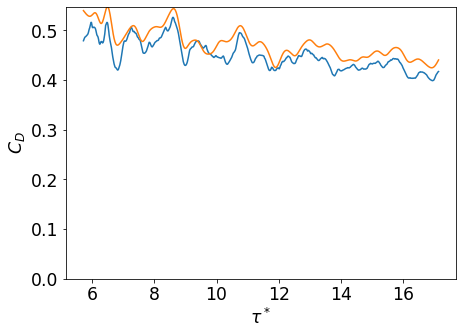

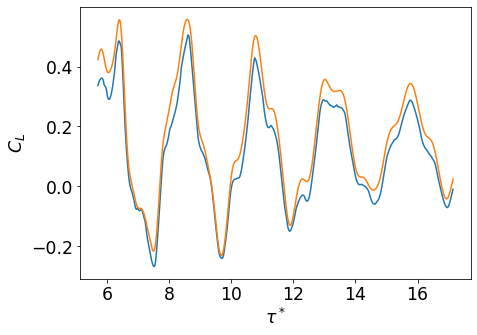

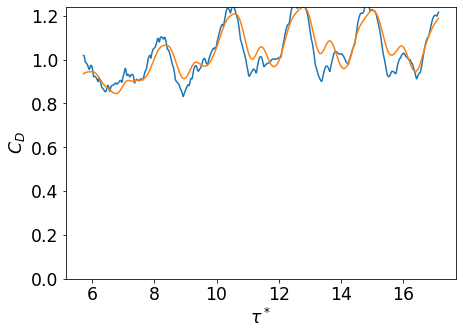

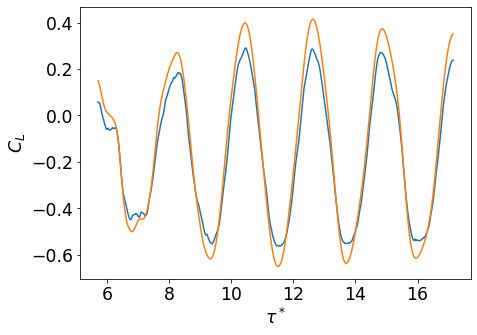

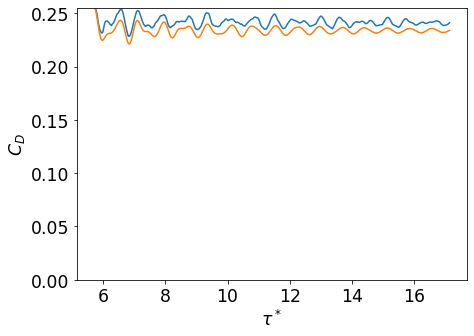

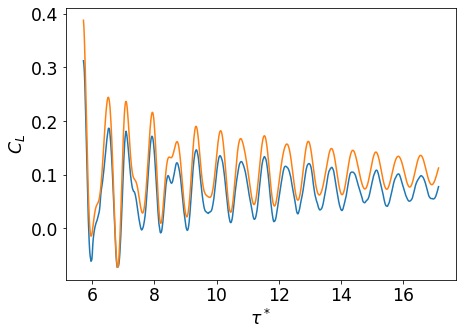

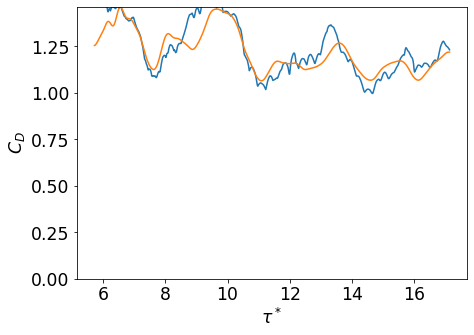

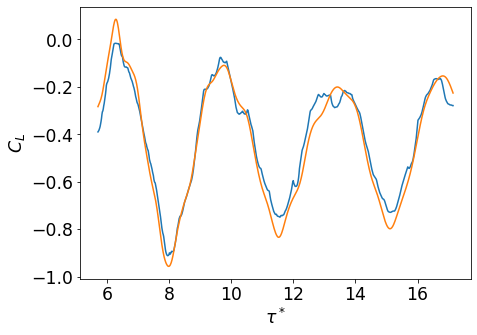

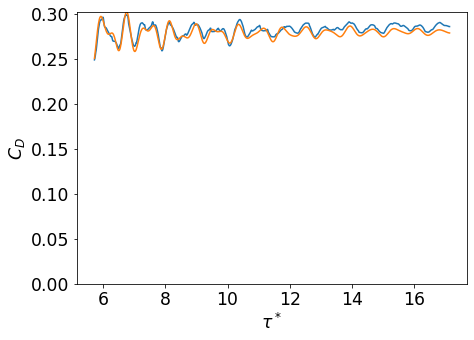

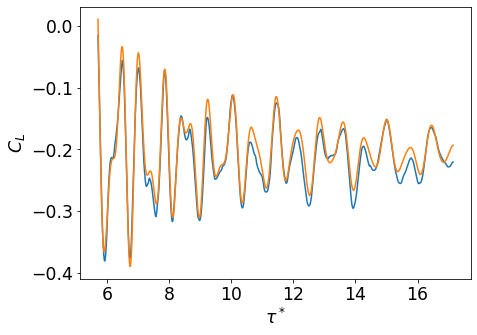

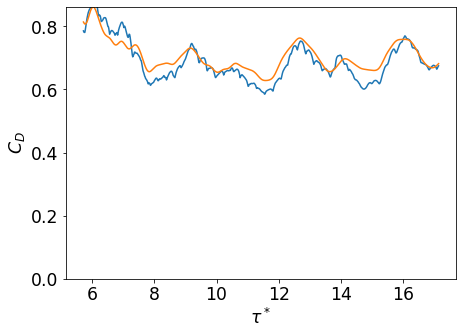

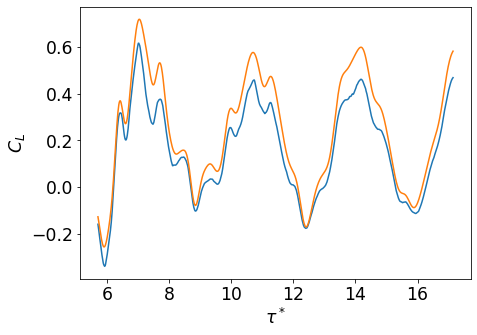

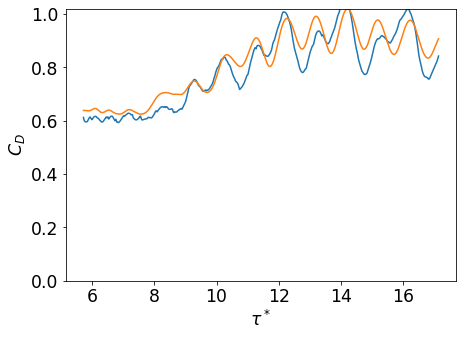

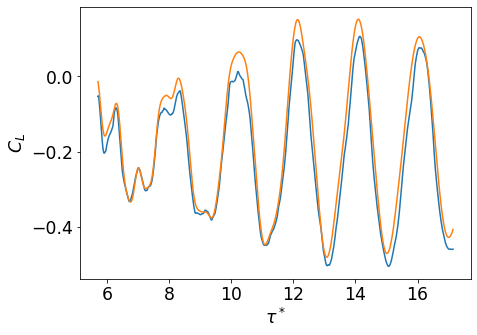

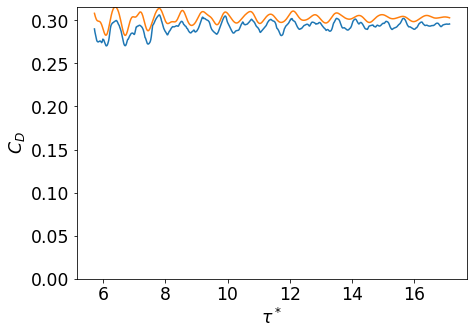

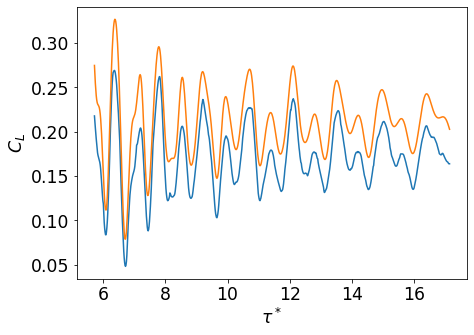

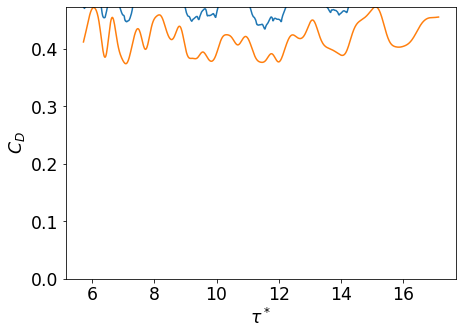

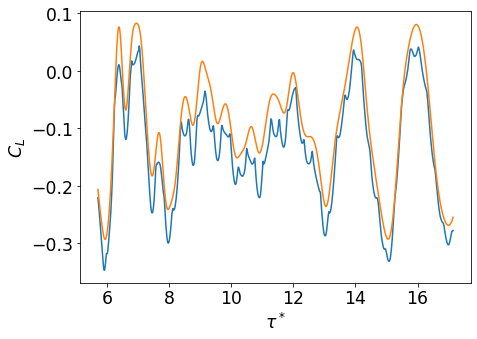

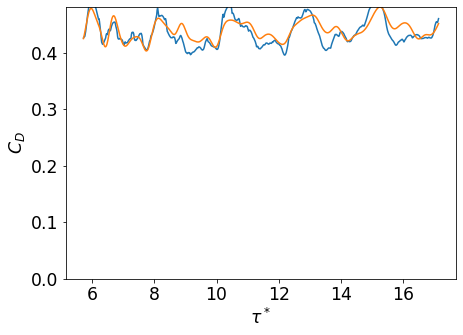

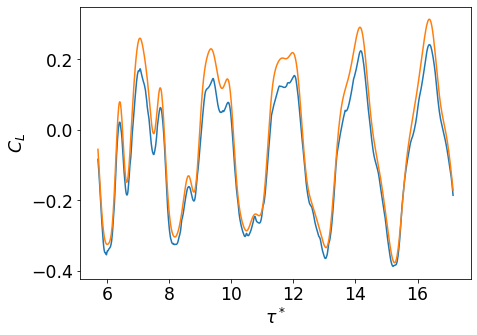

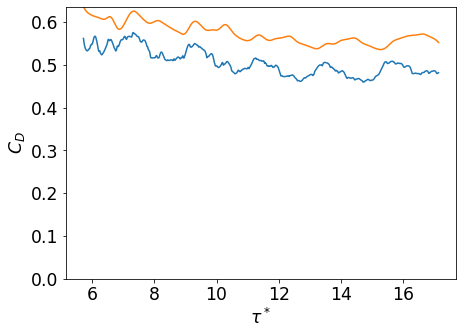

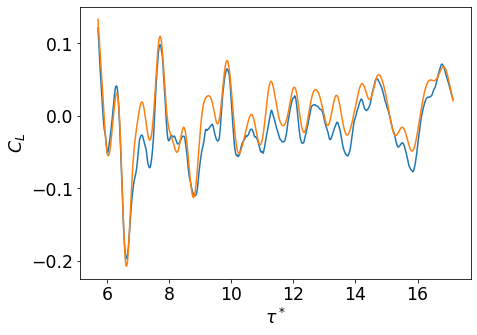

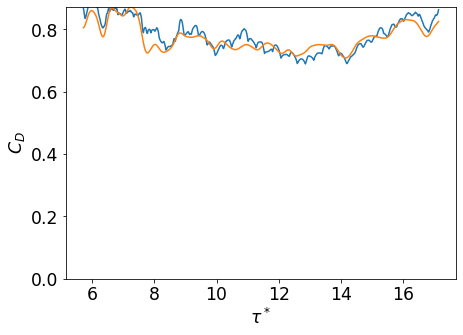

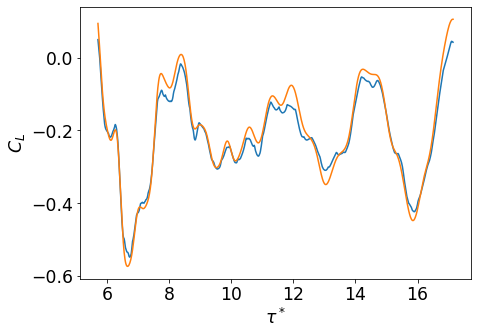

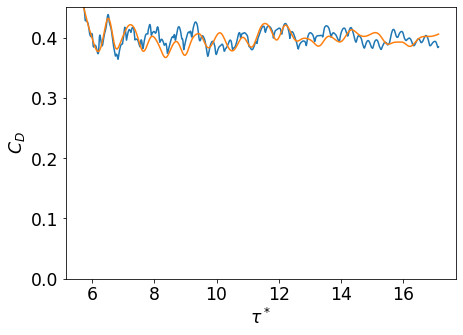

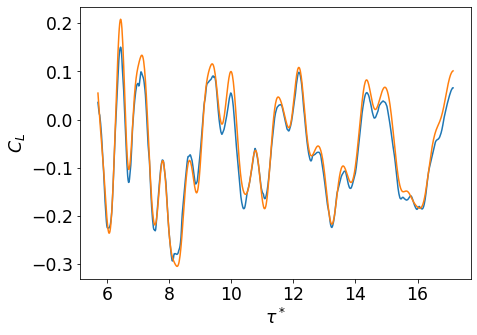

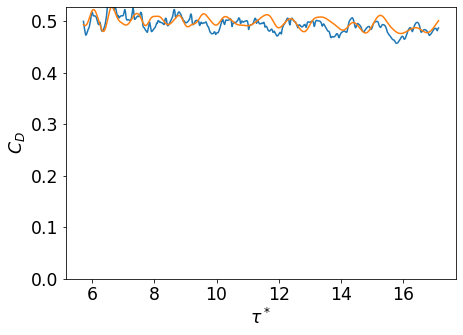

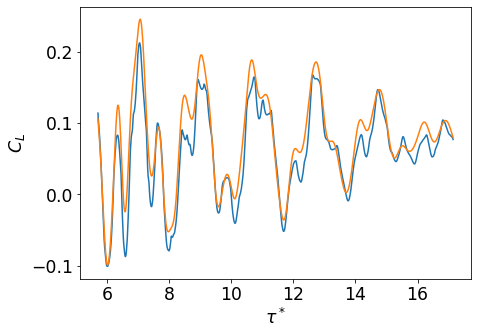

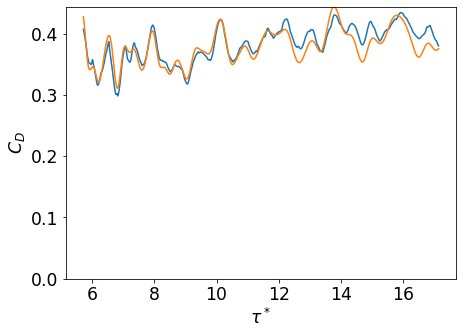

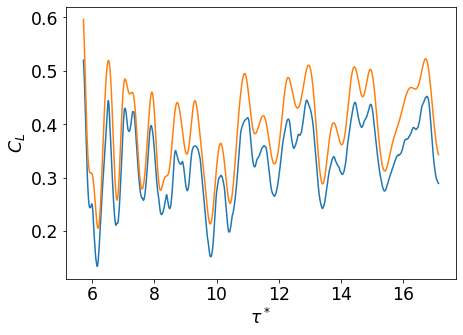

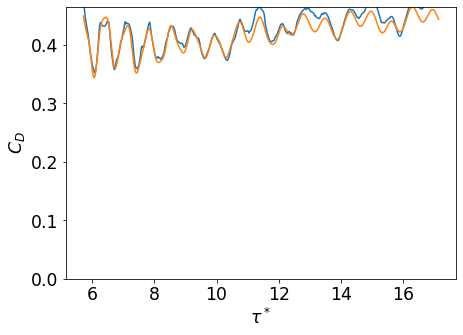

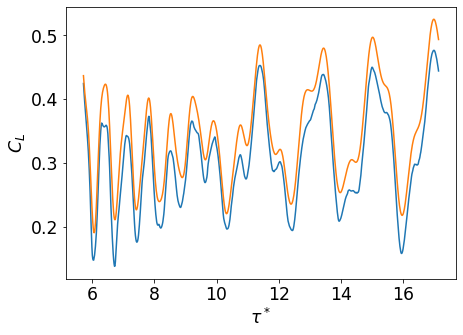

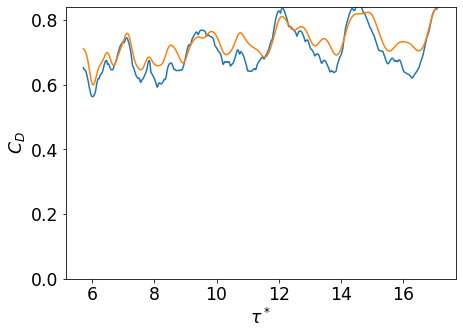

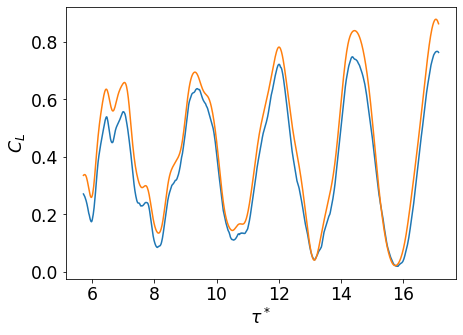

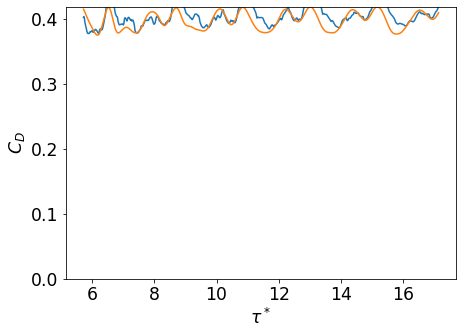

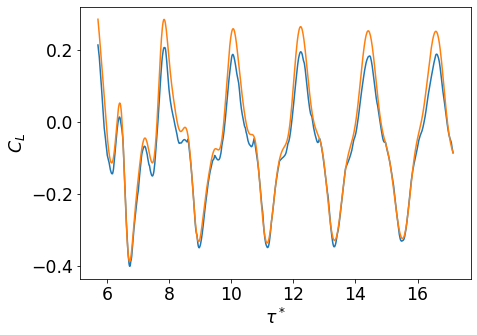

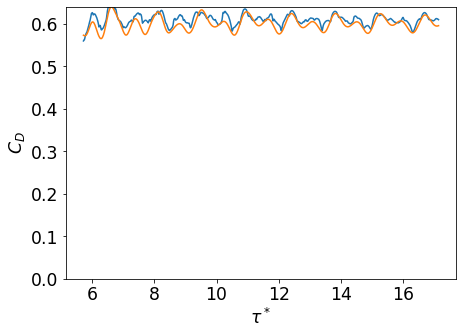

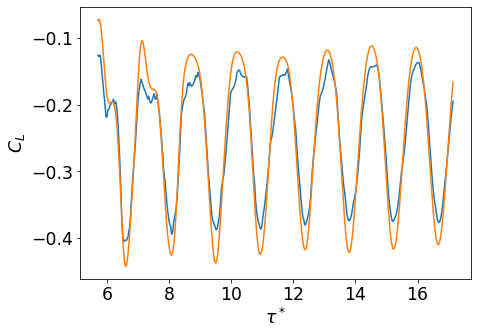

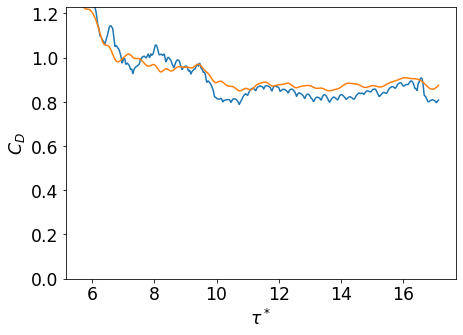

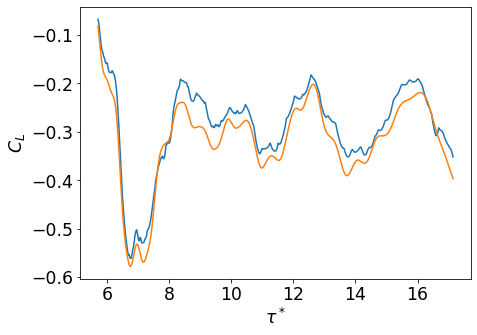

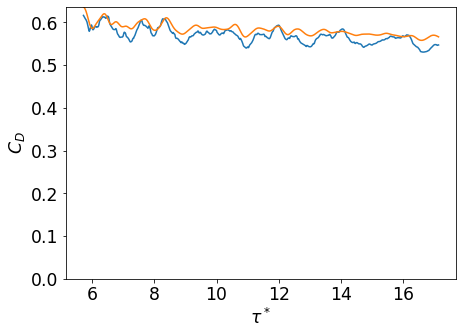

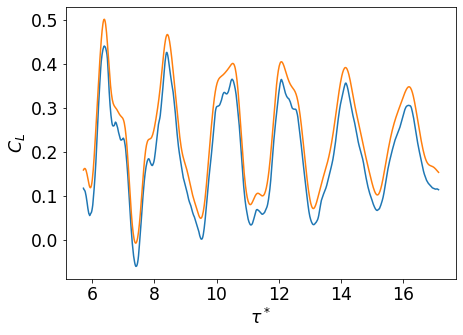

In [70]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (7, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

#TODO: automatically grab test geometry names
test_geometry_names = ('shape_34', 'shape_358', 'shape_74', 'shape_22', 'shape_183', 'shape_102', 'shape_326', 'shape_16', 'shape_107', 'shape_163', 'shape_76', 'shape_95', 'shape_52', 'shape_75', 'shape_67', 'shape_159', 'shape_343', 'shape_46', 'shape_147', 'shape_86', 'shape_325')
for shape_name in test_geometry_names:
    start_idx = 801*test_geometry_names.index(shape_name)
    end_idx = 801*(test_geometry_names.index(shape_name)+1)

    tstart = 20.0
    tend = 60.0
    Lm = 3.5
    Uinf = 1.0
    rho = 1.0
    S = surface_area(datasetf[shape_name]['full_field_coords'][0])
    norm_factor = 0.5*rho*(Uinf**2)*S
    taun = Uinf*np.linspace(tstart, tend, end_idx - start_idx)/Lm

    plt.figure()
    pred_Cd = pred_forces[start_idx:end_idx,0]/norm_factor
    target_Cd = target_forces[start_idx:end_idx,0]/norm_factor
    plt.plot(taun,pred_Cd, label='Predicted')
    plt.plot(taun,target_Cd, label='Target')
    #plt.legend()
    plt.ylim(0.0, tf.reduce_max(target_Cd))
    plt.xlabel(r'$\tau^*$')
    plt.ylabel(r'$C_D$')
    plt.savefig(f'{shape_name}_Cd.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

    plt.figure()
    pred_Cl = pred_forces[start_idx:end_idx,1]/norm_factor
    target_Cl = target_forces[start_idx:end_idx,1]/norm_factor
    plt.plot(taun, pred_Cl, label='Predicted')
    plt.plot(taun, target_Cl, label='Target')
    #plt.legend()
    plt.xlabel(r'$\tau^*$')
    plt.ylabel(r'$C_L$')
    plt.savefig(f'{shape_name}_Cl.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [73]:
#export legend separately
#https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
    
plt.figure()
plt.plot(taun, pred_Cl, label='Predicted')
plt.plot(taun, target_Cl, label='Target')
pltlegend = plt.legend(ncol=2, bbox_to_anchor=(11.0, 11.0))
export_legend(pltlegend)
plt.close()